## Image Focus and Astigmatism Classifier
**Author:** [Aaron Woods](https://aaronwoods.info)  
**Date Created:** September 12, 2023  
**Description:** This script provides an end-to-end machine learning pipeline to classify images as either "In Focus" or "Out of Focus", and additionally identifies astigmatism-related issues.  
**Repository:** [Image Classification on VSCode](https://insiders.vscode.dev/tunnel/midnightsim/c:/Users/User/Desktop/Image-Classification)

### Overview
The script features a comprehensive pipeline that ingests data from Excel spreadsheets and feeds it into various machine learning models. The design is modular, allowing for easy adaptability to address different image classification problems, including focus quality and astigmatism detection.


## Setup

In [36]:
# ------------------------------
# TensorFlow Installation with GPU Support
# ------------------------------
# Note: TensorFlow versions above 2.10 are not supported on GPUs on native Windows installations.
# For more details, visit: https://www.tensorflow.org/install/pip#windows-wsl2_1
# Uncomment the following line to install TensorFlow if needed.
# %pip install "tensorflow<2.11"

# ------------------------------
# System and TensorFlow Info Check
# ------------------------------
# Import necessary libraries and initialize an empty dictionary to store system information.
import platform
system_info = {"Platform": platform.platform(), "Python Version": platform.python_version()}

# Try importing TensorFlow and collecting relevant system information.
try:
    import tensorflow as tf
    system_info.update({
        "TensorFlow Version": tf.__version__,
        "Num GPUs Available": len(tf.config.list_physical_devices('GPU'))
    })
    system_info['Instructions'] = (
        "You're all set to run your model on a GPU." 
        if system_info['Num GPUs Available'] 
        else (
            "No GPUs found. To use a GPU, follow these steps:\n"
            "  1. Install NVIDIA drivers for your GPU.\n"
            "  2. Install a compatible CUDA toolkit.\n"
            "  3. Install the cuDNN library.\n"
            "  4. Make sure to install the GPU version of TensorFlow."
        )
    )
except ModuleNotFoundError:
    system_info['Instructions'] = (
        "TensorFlow is not installed. "
        "Install it using pip by running: !pip install tensorflow"
    )

# Format and display the gathered system information.
formatted_info = "\n".join(f"{key}: {value}" for key, value in system_info.items())
print(formatted_info)

Platform: Windows-10-10.0.17763-SP0
Python Version: 3.9.18
TensorFlow Version: 2.10.1
Num GPUs Available: 1
Instructions: You're all set to run your model on a GPU.


In [47]:
# ------------------------------
# Package Installation (Optional)
# ------------------------------
# Uncomment the following lines to install required packages if running on a new machine.
# To suppress the output, we use '> /dev/null 2>&1'.
# %pip install openpyxl numpy pandas matplotlib protobuf seaborn scikit-learn tensorflow 


  Using cached openpyxl-3.1.2-py2.py3-none-any.whl (249 kB)
  Using cached et_xmlfile-1.1.0-py3-none-any.whl (4.7 kB)
Note: you may need to restart the kernel to use updated packages.


In [37]:

# ------------------------------
# Import Libraries
# ------------------------------

# Standard Libraries
import os, sys, random, math, glob, logging
from datetime import datetime
from collections import defaultdict

# Third-Party Libraries
import numpy as np
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight
from sklearn.utils.class_weight import compute_class_weight
from IPython.display import clear_output
from collections import Counter
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer

# TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.callbacks import TensorBoard, Callback
from tensorflow.keras.applications import InceptionV3, ResNet50
from keras.models import load_model
from tensorflow.data import Dataset

import pickle

# Type Annotations
from typing import List, Dict, Tuple, Union, Any, Optional


Note: you may need to restart the kernel to use updated packages.


The system cannot find the path specified.


## Configuration

In [38]:
# Configuration dictionary
config = {
    'Experiment': {
        'NAME': "Version8",  # Experiment name
        'RANDOM_SEED': 42,  # Seed for reproducibility
        'PROBLEM_TYPE': 'Multi-Output',  # Problem type: Binary, Multi-Class, Multi-Output, Multi-Label
    },
    'Model': {
        'IMG_SIZE': 224,  # Image input size
        'BATCH_SIZE': 32,  # Batch size for training
        'TRAIN_SIZE': 0.8,  # Fraction of data to use for training
        'VAL_SIZE': 0.5,  # Fraction of data to use for validation
    },
    'Labels': {
        'MAPPINGS': {  # Class label mappings
            'Focus_Label': {'SharpFocus': 0, 'SlightlyBlurred': 1, 'HighlyBlurred': 2},
            'StigX_Label': {'OptimalStig_X': 0, 'ModerateStig_X': 1, 'SevereStig_X': 2},
            'StigY_Label': {'OptimalStig_Y': 0, 'ModerateStig_Y': 1, 'SevereStig_Y': 2},
        }
    },
    'Augmentation': {  # Data augmentation parameters
        'rotation_factor': 0.002,
        'height_factor': (-0.18, 0.18),
        'width_factor': (-0.18, 0.18),
        'contrast_factor': 0.5,
    }
}


In [39]:
# Set random seed for reproducibility
np.random.seed(config['Experiment']['RANDOM_SEED'])
tf.random.set_seed(config['Experiment']['RANDOM_SEED'])

## Load and Preprocess the data

### Functions for Preparation of CSV

In [40]:
# Read the data

def read_csv(config: Dict):
    # Functionality to read the data
    data_file_path = os.path.join(config['Paths']['NEW_BASE_PATH'], config['Paths']['DATA_FILE'])
    if not os.path.exists(data_file_path):
        raise FileNotFoundError(f"Error: File does not exist - {data_file_path}")
    try:
        data = pd.read_csv(data_file_path, usecols=config['CSV']['COLUMNS_TO_READ'])
        print("---> Data read successfully.")
        sample_frac = config.get('SAMPLE_FRAC', 1.0)
        if 0 < sample_frac < 1.0:
            data = data.sample(frac=sample_frac).reset_index(drop=True)
            print(f"---> Data sampled: Using {sample_frac * 100}% of the available data.")
    except Exception as e:
        raise ValueError(f"Error: Could not read data - {e}") from e
    return data

def update_image_paths(df):
    old_base_path = config['Paths']['OLD_BASE_PATH']
    new_base_path = config['Paths']['NEW_BASE_PATH']
    df['ImageFile'] = df['ImageFile'].str.replace(old_base_path, new_base_path, regex=False)
    print("---> Image paths updated.")
    return df

def clean_csv(df: pd.DataFrame) -> pd.DataFrame:
    def is_valid_string(image_path) -> bool:
        return isinstance(image_path, str)
    def does_file_exist(image_path) -> bool:
        return os.path.exists(image_path)
    def can_image_be_read(image_path) -> bool:
        img = cv2.imread(image_path)
        return img is not None
    invalid_rows = []
    removal_reasons = defaultdict(int)  # Dictionary to count reasons for removal
    for index, row in df.iterrows():
        image_path = row['ImageFile']
        reason = None  # Initialize removal reason as None
        if not is_valid_string(image_path):
            reason = "Invalid ImageFile value - not a string"
        elif not does_file_exist(image_path):
            reason = "File does not exist"
        elif not can_image_be_read(image_path):
            reason = "Image can't be read"
        if reason:
            removal_reasons[reason] += 1  # Count the reason for removal
            invalid_rows.append(index)
    # Drop invalid rows
    df.drop(index=invalid_rows, inplace=True)
    df.reset_index(drop=True, inplace=True)
    # Print summary of removal reasons
    print("Summary of row removals:")
    for reason, count in removal_reasons.items():
        print(f"{count} rows removed due to: {reason}")
    return df


### Generating labels

In [41]:
# Generating labels
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
import numpy as np
import pandas as pd
from typing import Dict

def generate_thresholds(label_key):
    low_key = f"{label_key.split('_')[0].upper()}_LOW"
    high_key = f"{label_key.split('_')[0].upper()}_HIGH"
    return config.get('Thresholds', {}).get(low_key, 0), config.get('Thresholds', {}).get(high_key, 0)

def generate_single_label(df_copy, label_key, offset_column, choices_dict):
    low_threshold, high_threshold = generate_thresholds(label_key)
    conditions = [
        (df_copy[offset_column].abs() <= low_threshold),
        (df_copy[offset_column].abs() > low_threshold) & (df_copy[offset_column].abs() <= high_threshold),
        (df_copy[offset_column].abs() > high_threshold)
    ]
    choices = list(choices_dict.keys())
    df_copy[label_key] = np.select(conditions, choices, default='Unknown')
    le = LabelEncoder()
    df_copy[label_key] = le.fit_transform(df_copy[label_key])
    return le

def generate_labels(df: pd.DataFrame):
    print("---> Generating labels for Focus, StigX, and StigY...")
    labels_config = config.get('Labels', {}).get('MAPPINGS', {})
    offset_column_mapping = {'Focus_Label': 'Focus_Offset (V)', 'StigX_Label': 'Stig_Offset_X (V)', 'StigY_Label': 'Stig_Offset_Y (V)'}

    df_copy = df.copy()
    label_encoders = {}

    for label_key, choices_dict in labels_config.items():
        offset_column = offset_column_mapping.get(label_key)
        if not offset_column:
            print(f"Warning: No offset column mapping found for '{label_key}'. Skipping label generation.")
            continue
        if offset_column not in df.columns:
            print(f"Warning: Column '{offset_column}' not found in DataFrame. Skipping label generation for '{label_key}'.")
            continue
        label_encoders[label_key] = generate_single_label(df_copy, label_key, offset_column, choices_dict)
        print(f"---> Labels generated for {label_key}")

    if config.get('Experiment', {}).get('PROBLEM_TYPE') == 'Multi-Output':
        df_copy['Multi_Output_Labels'] = df_copy.apply(lambda row: [row[key] for key in labels_config.keys()], axis=1)
        print("---> Multi-Output Labels generated.")
        
    return df_copy, label_encoders


### Shuffling and Splitting the Data

In [42]:
# Shuffling and Splitting the data

def shuffle_and_reset_index(data):
    print("---> Shuffling and resetting index...")
    shuffled_df = data.sample(frac=1, random_state=config['Experiment']['RANDOM_SEED']).reset_index(drop=True)
    print("---> Data shuffled and index reset.")
    return shuffled_df

def prepare_datasets(df: pd.DataFrame):
    """Prepare training, validation, and test datasets."""
    # Check if DataFrame is empty
    if df is None or df.empty:
        print("Warning: DataFrame is empty. Cannot proceed with data preparation.")
        return {'train': None, 'valid': None, 'test': None}
    # Split Data
    try:
        train_df, temp_df = train_test_split(df, test_size=1 - config['Model']['TRAIN_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
        val_df, test_df = train_test_split(temp_df, test_size=1 - config['Model']['VAL_SIZE'], random_state=config['Experiment']['RANDOM_SEED'])
    except ValueError:
        print("Not enough data to split into training, validation, and test sets.")
        return {'train': None, 'valid': None, 'test': None}
    print("---> Data split into training, validation, and test sets.")
    return {'train': train_df, 'valid': val_df, 'test': test_df}

### Computting Class Weights

In [43]:
# Compute class weights

from collections import Counter
from sklearn.preprocessing import LabelEncoder, MultiLabelBinarizer
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import pandas as pd
from typing import Dict


def compute_multi_output_class_weights(split: str, df: pd.DataFrame, label: str, label_encoders: Dict[str, LabelEncoder], all_records: List[Dict]) -> None:
    unique_labels = df[label].unique()
    class_weights = compute_class_weight('balanced', classes=np.unique(unique_labels), y=df[label])
    class_weights_dict = dict(zip(unique_labels, class_weights))
    for cls, weight in class_weights_dict.items():
        cnt = Counter(df[label])[cls]
        original_class = label_encoders[label].inverse_transform([cls])[0]
        all_records.append({'split': split, 'label': label, 'class': original_class, 'Count': cnt, 'Weight': weight})

def compute_multi_label_class_weights(split: str, df: pd.DataFrame, label: str, label_encoders: Dict[str, LabelEncoder], all_records: List[Dict]) -> None:
    label_data = df[label].values
    unique_labels = np.unique(label_data)
    class_weights = compute_class_weight('balanced', classes=np.unique(unique_labels), y=label_data)
    class_weights_dict = dict(zip(unique_labels, class_weights))
    for cls, weight in class_weights_dict.items():
        cnt = Counter(label_data)[cls]
        original_class = label_encoders[label].inverse_transform([cls])[0]
        all_records.append({'split': split, 'label': label, 'class': original_class, 'Count': cnt, 'Weight': weight})

def compute_and_store_class_weights(datasets: Dict[str, pd.DataFrame], label_encoders: Dict[str, LabelEncoder]) -> pd.DataFrame:
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE', 'Binary')
    all_records = []
    
    for split, df in datasets.items():
        if df is None:
            continue
        for label in config['Labels']['MAPPINGS']:
            if problem_type == 'Multi-label':
                compute_multi_label_class_weights(split, df, label, label_encoders, all_records)
            else:
                compute_multi_output_class_weights(split, df, label, label_encoders, all_records)
                
    df_class_weights = pd.DataFrame.from_records(all_records)
    df_class_weights.set_index(['split', 'label', 'class'], inplace=True)
    return df_class_weights

### Creating Tensorflow Datasets

In [44]:
# Create TensorFlow datasets

def create_tf_datasets_from_dfs(dfs: Dict[str, pd.DataFrame], include_offset=False) -> Dict[str, Dict[str, Any]]:
    """
    Create TensorFlow datasets from DataFrames for training, validation, and testing.
    Parameters:
    - dfs: Dictionary containing DataFrames for 'train', 'val', and 'test'.
    Returns:
    - Dictionary containing TensorFlow datasets for each split.
    """
    problem_type = config.get('Experiment', {}).get('PROBLEM_TYPE')
    batch_size = config.get('Model', {}).get('BATCH_SIZE', 32)
    AUTOTUNE = tf.data.AUTOTUNE
    # Create preprocessing and augmentation layers
    preprocessing_layers = create_preprocessing_layers()
    augmentation_layers = create_augmentation_layers()
    # Initialize output dictionary
    tf_datasets = {'train': {}, 'valid': {}, 'test': {}}
    
    def load_and_preprocess_image(file_path, label, offset=None, augment=False):
        file_path_str = file_path.numpy().decode('utf-8')
        image = read_and_convert_image(file_path_str)
        image = preprocessing_layers(image)
        label = tf.cast(label, tf.int32)  # Explicitly casting to tf.int32
        offset = tf.cast(offset, tf.float32) if offset is not None else None
        if augment:
            image = augmentation_layers(image)
            image = tf.clip_by_value(image, 0.0, 1.0)
        return (image, label, offset) if include_offset else (image, label)
    
    
    offset_column_mapping = {
        'Focus_Label': 'Focus_Offset (V)',
        'StigX_Label': 'Stig_Offset_X (V)',
        'StigY_Label': 'Stig_Offset_Y (V)'}
    for split, df in dfs.items():
        augment_data = (split == 'train')
        if problem_type in ['Multi-Class', 'Binary']:
            for label in ['Focus_Label', 'StigX_Label', 'StigY_Label']:
                offset_column = offset_column_mapping.get(label)
                offsets_tensor = df[offset_column].values if include_offset else None
                
                ds = tf.data.Dataset.from_tensor_slices((df['ImageFile'].values, df[label].values, offsets_tensor))

                # Handling offset inside the lambda
                ds = ds.map(lambda file_path, label, offset: tf.py_function(
                    func=load_and_preprocess_image,
                    inp=[file_path, label, offset if offset is not None else tf.constant([], dtype=tf.float32), augment_data],
                    Tout=[tf.float32, label.dtype, tf.float32] if include_offset else [tf.float32, label.dtype]
                ))
                
                ds = ds.batch(batch_size)
                ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
                tf_datasets[split][label] = ds

        elif problem_type == 'Multi-Output':
            labels_tensor = df[['Focus_Label', 'StigX_Label', 'StigY_Label']].values
            offsets_tensor = df[['Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']].values if include_offset else None
            ds = tf.data.Dataset.from_tensor_slices((df['ImageFile'].values, labels_tensor, offsets_tensor))
            
            # Handling offset inside the lambda
            ds = ds.map(lambda file_path, label, offset: tf.py_function(
                func=load_and_preprocess_image,
                inp=[file_path, label, offset if offset is not None else tf.constant([], dtype=tf.float32), augment_data],
                Tout=[tf.float32, label.dtype, tf.float32] if include_offset else [tf.float32, label.dtype]
            ))
            
            ds = ds.batch(batch_size)
            ds = ds.cache().prefetch(buffer_size=AUTOTUNE)
            tf_datasets[split]['Multi_Output'] = ds

        else:
            print("Unknown problem type specified in config. Please check.")

    return tf_datasets



# Image Augmentation and Preprocessing

def create_preprocessing_layers() -> keras.Sequential:
    """Create preprocessing layers for resizing and rescaling images."""
    img_size = config['Model']['IMG_SIZE']
    return keras.Sequential([
        layers.Resizing(img_size, img_size),
        layers.Rescaling(1./255)
    ])

def create_augmentation_layers() -> keras.Sequential:
    """Create data augmentation layers."""
    aug_config = config['Augmentation']
    try:
        return keras.Sequential([
            layers.RandomFlip("horizontal"),
            layers.RandomFlip("vertical"),
            layers.RandomRotation(aug_config['rotation_factor']),
            layers.RandomTranslation(
                height_factor=aug_config['height_factor'],
                width_factor=aug_config['width_factor'],
                fill_mode="reflect"
            ),
            layers.RandomContrast(aug_config['contrast_factor']),
        ])
        
    except Exception as e:
        print(f"An error occurred while creating augmentation layers: {e}")
        return None

def read_and_convert_image(file_path: str) -> tf.Tensor:
    """Read an image from a file and convert it to a 3-channel tensor."""
    image = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print("Failed to read the image.")
        return None
    image = tf.convert_to_tensor(image, dtype=tf.float32)
    image = tf.expand_dims(image, axis=-1)
    return tf.image.grayscale_to_rgb(image)


### Main Function for Data Preparation

In [45]:
# Configure for dataset creation

csv_config = {
    'CSV': {
        'COLUMNS_TO_READ': ['ImageFile', 'Focus_Offset (V)', 'Stig_Offset_X (V)', 'Stig_Offset_Y (V)']
    },
    'Thresholds': {
        'FOCUS_LOW': 30,  # Lower focus threshold
        'FOCUS_HIGH': 60,  # Upper focus threshold
        'STIGX_LOW': 1,  # Lower astigmatism threshold
        'STIGX_HIGH': 2,  # Upper astigmatism threshold
        'STIGY_LOW': 1,  # Lower astigmatism threshold
        'STIGY_HIGH': 2,  # Upper astigmatism threshold
    },
    'Paths': {  # Data and model paths
        'DATA_FILE': "combined_output.csv",
        'OLD_BASE_PATH': "D:\\DOE\\",
        'NEW_BASE_PATH': "Y:\\User\\Aaron-HX38\\DOE\\",
        # 'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Documents\\GitHub\\Image-Classification\\",
        # 'NEW_BASE_PATH': "C:\\Users\\aaron.woods\\OneDrive - Thermo Fisher Scientific\\Desktop\\Dec 24\\",
    },
    'SAMPLE_FRAC': 1.0,  # Fraction of the data to use for quicker prototyping. 1.0 means use all data.
}
config.update(csv_config)


# Main function to integrate all steps
def main_pipeline(config: Dict):
    print("===== Preprocessing CSV Data =====")
    data = read_csv(config)
    data = update_image_paths(data)
    data = clean_csv(data)
    data, label_encoders = generate_labels(data)
    data = shuffle_and_reset_index(data)
    print("===== Preparing TensorFlow Datasets =====")
    datasets = prepare_datasets(data)
    info = compute_and_store_class_weights(datasets, label_encoders)
    datasets = create_tf_datasets_from_dfs(datasets, include_offset=True)
    print("===== Preprocessing Complete =====")
    return datasets, label_encoders, info

datasets, label_encoders, info = main_pipeline(config)

===== Preprocessing CSV Data =====
---> Data read successfully.
---> Image paths updated.


KeyboardInterrupt: 

## Visualize the data

In [ ]:
print(datasets)

{'train': {'Multi_Output': <PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>}, 'valid': {'Multi_Output': <PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>}, 'test': {'Multi_Output': <PrefetchDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=<unknown>, dtype=tf.int32, name=None), TensorSpec(shape=<unknown>, dtype=tf.float32, name=None))>}}


In [ ]:
print(info)

                                   Count    Weight
split label       class                           
train Focus_Label SharpFocus        8019  1.278124
                  SlightlyBlurred   3344  0.638982
                  HighlyBlurred     4009  1.532297
      StigX_Label OptimalStig_X     8324  1.588345
                  SevereStig_X      3822  0.615569
                  ModerateStig_X    3226  1.340659
      StigY_Label OptimalStig_Y     8481  1.701195
                  SevereStig_Y      3879  0.604174
                  ModerateStig_Y    3012  1.320959
valid Focus_Label HighlyBlurred      502  1.275564
                  SlightlyBlurred    431  0.648111
                  SharpFocus         988  1.485692
      StigX_Label ModerateStig_X     402  1.592869
                  SevereStig_X       487  0.620478
                  OptimalStig_X     1032  1.314853
      StigY_Label ModerateStig_Y     384  1.667535
                  SevereStig_Y       471  0.600688
                  OptimalStig_Y

C:\Users\User\AppData\Local\Temp\ipykernel_7728\3640111345.py:24: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_ticks, rotation=90, fontsize=8)


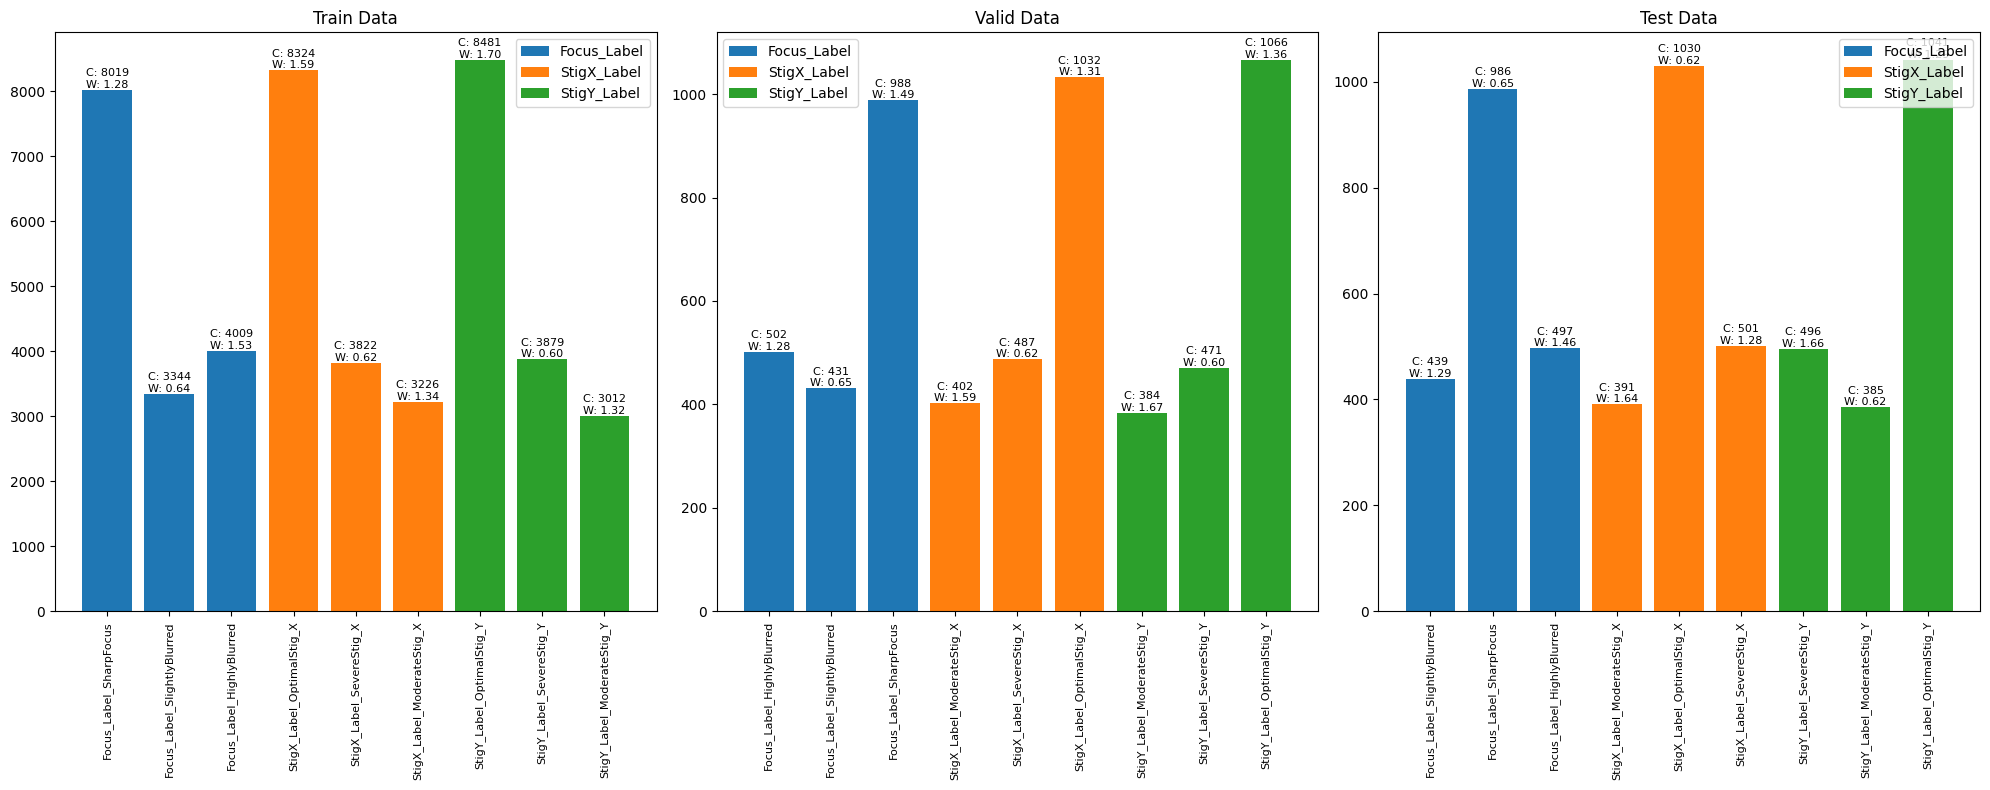

In [ ]:
def add_annotations(ax, bars, sub_df):
    for bar, (_, row) in zip(bars, sub_df.iterrows()):
        x = bar.get_x() + bar.get_width() / 2.0
        y = bar.get_height()
        ax.annotate(f"C: {int(row['Count'])}\nW: {row['Weight']:.2f}", 
                    (x, y), 
                    ha='center', 
                    va='bottom', 
                    fontsize=8)

def plot_single_split(ax, df, split, problem_type):
    filtered_df = df.loc[split]
    x_ticks = []
    
    labels = filtered_df.index.get_level_values('label').unique()
    for label in labels:
        sub_df = filtered_df.loc[label]
        bars = ax.bar(sub_df.index, sub_df['Count'], label=f"{label}")
        add_annotations(ax, bars, sub_df)
        
        x_ticks.extend([f"{label}_{cls}" for cls in sub_df.index])
    
    ax.legend()
    ax.set_xticklabels(x_ticks, rotation=90, fontsize=8)
    ax.set_title(f"{split.capitalize()} Data")

def plot_dataset_info(df, config):
    problem_type = config['Experiment']['PROBLEM_TYPE']
    splits = ['train', 'valid', 'test']
    
    fig, axs = plt.subplots(1, len(splits), figsize=(20, 8))
    
    for i, split in enumerate(splits):
        plot_single_split(axs[i], df, split, problem_type)
        
    plt.tight_layout()
    plt.show()

# Example usage
plot_dataset_info(info, config)


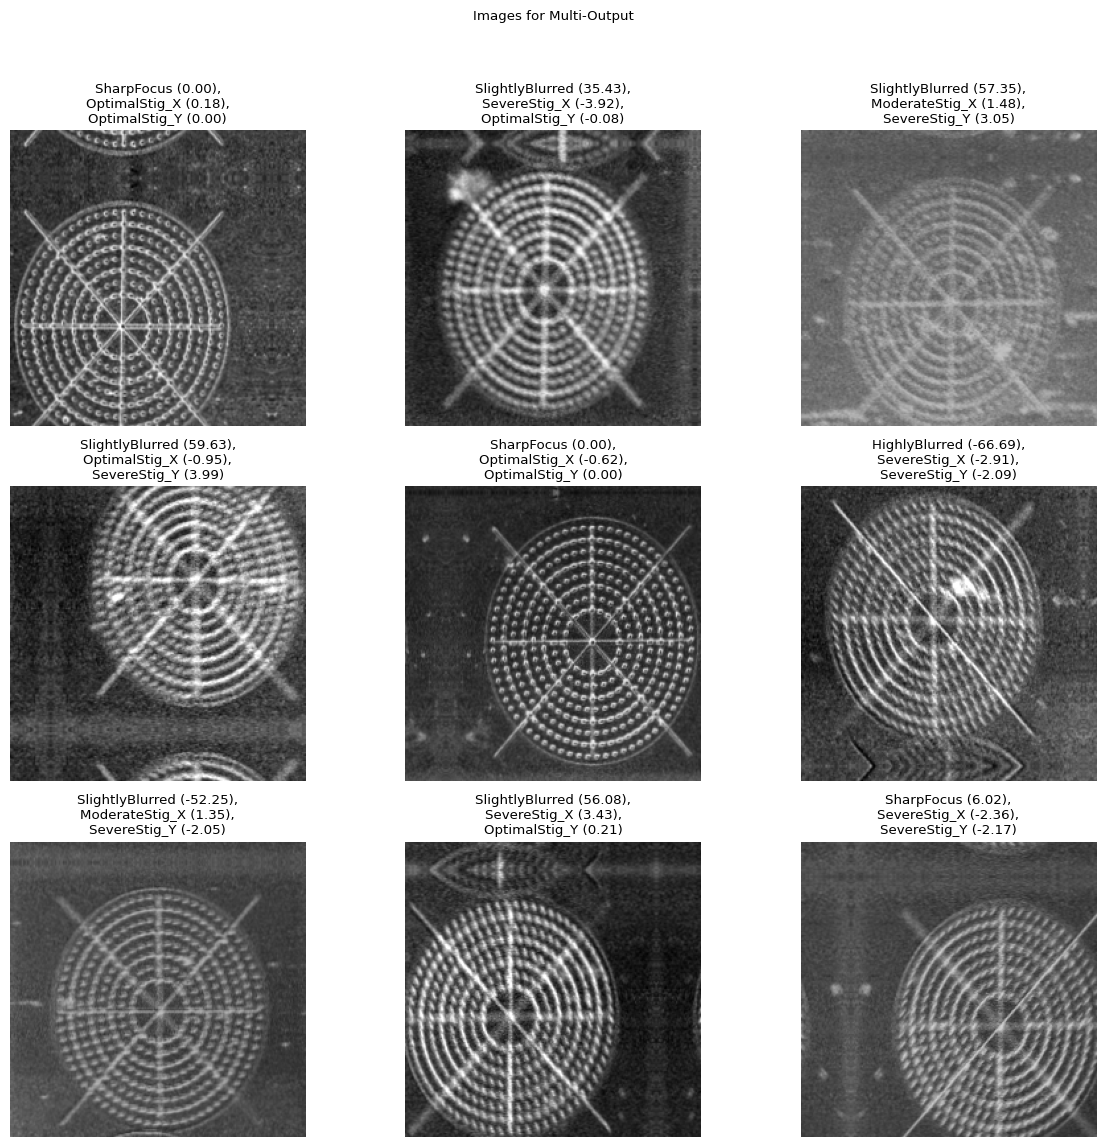

In [ ]:
import textwrap

# Assume label_encoders and config are available
label_keys = ['Focus_Label', 'StigX_Label', 'StigY_Label']
problem_type = config['Experiment']['PROBLEM_TYPE']

plt.rcParams.update({'font.size': 8})  # Reduce font size
fig, axes = plt.subplots(3, 3, figsize=(12, 12))  # Enlarge figure size

if problem_type in ['Multi-Class', 'Binary']:
    for label_key in label_keys:
        label_encoder = label_encoders.get(label_key, None)
        fig.suptitle(f"Images for {label_key}")

        # Take one batch from the training dataset
        for data in datasets['train'][label_key].take(1):
            images, labels = data[:2]
            offsets = data[2] if len(data) > 2 else None  # Include offsets if they exist

            # Loop over the batch to plot images, labels, and offsets
            for i in range(min(len(images), 9)):  # Show up to 9 images
                ax = axes[i // 3, i % 3]
                ax.imshow(images[i].numpy())

                label_value = labels[i].numpy()
                offset_value = offsets[i].numpy() if offsets is not None else "N/A"

                # Use label encoder to get original label name if available
                if label_encoder:
                    label_name = label_encoder.inverse_transform([label_value])[0]
                else:
                    label_name = label_value

                ax.set_title(f"{label_name} (Offset: {offset_value})")
                ax.axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()

elif problem_type == 'Multi-Output':
    fig.suptitle("Images for Multi-Output")

    # Take one batch from the training dataset
    for data in datasets['train']['Multi_Output'].take(1):
        images, labels = data[:2]
        offsets = data[2] if len(data) > 2 else None  # Include offsets if they exist

        # Loop over the batch to plot images, labels, and offsets
        for i in range(min(len(images), 9)):  # Show up to 9 images
            ax = axes[i // 3, i % 3]
            ax.imshow(images[i].numpy())

            label_values = labels[i].numpy()
            offset_values = offsets[i].numpy() if offsets is not None else ["N/A"] * len(label_keys)
            # Round offset values to 2 decimal places
            offset_values = [f"{offset:.2f}" for offset in offset_values]

            label_names = []
            for label_value, label_key in zip(label_values, label_keys):
                label_encoder = label_encoders.get(label_key, None)
                if label_encoder:
                    label_names.append(label_encoder.inverse_transform([label_value])[0])
                else:
                    label_names.append(str(label_value))

            title_text = ", ".join(f"{name} ({offset})" for name, offset in zip(label_names, offset_values))
            ax.set_title("\n".join(textwrap.wrap(title_text, 30)))  # Wrap text to limit the width
            ax.axis("off")

        plt.tight_layout(rect=[0, 0.03, 1, 0.95])
        plt.show()
else:
    print("Unknown problem type specified in config. Please check.")


## Train the Models

### Define the Models

In [ ]:
# Transfer learning models
def create_transfer_model(base_model, input_shape: tuple, num_classes: int, hidden_units: list, dropout_rate: float, regularizer_rate: float) -> keras.Model:
    """Creates a transfer learning model based on a given base model."""
    base_model.trainable = False

    model = keras.Sequential([
        base_model,
        layers.GlobalAveragePooling2D()
    ])

    for units in hidden_units:
        model.add(layers.Dense(units, kernel_regularizer=keras.regularizers.l2(regularizer_rate), bias_regularizer=keras.regularizers.l2(regularizer_rate)))
        model.add(layers.LeakyReLU())
        model.add(layers.Dropout(dropout_rate))
        
    activation, units = determine_activation_and_units(num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model

def create_mobilenetv2_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a MobileNetV2 based transfer learning model."""
    base_model = tf.keras.applications.MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_inceptionv3_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates an InceptionV3 based transfer learning model."""
    base_model = tf.keras.applications.InceptionV3(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [128, 64], 0.5, 0.001)

def create_resnet50_transfer_model(input_shape: tuple, num_classes: int) -> keras.Model:
    """Creates a ResNet50 based transfer learning model."""
    base_model = tf.keras.applications.ResNet50(input_shape=input_shape, include_top=False, weights='imagenet')
    return create_transfer_model(base_model, input_shape, num_classes, [256, 128], 0.5, 0.001)

# Define the function to create a basic CNN model
def create_basic_cnn_model(input_shape, num_classes):
    conv2d_filter_size = (3, 3)
    conv2d_activation = 'relu'
    dense_activation = 'relu'
    num_conv_blocks = 3

    model = tf.keras.models.Sequential()

    # Explicitly define the input shape
    model.add(tf.keras.layers.Input(shape=input_shape))

    for _ in range(num_conv_blocks):
        model.add(tf.keras.layers.Conv2D(32 * (2**_), conv2d_filter_size, activation=conv2d_activation, padding='same'))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.MaxPooling2D((2, 2)))

    model.add(tf.keras.layers.GlobalAveragePooling2D())
    model.add(tf.keras.layers.Dense(128, activation=dense_activation))

    activation, units = determine_activation_and_units(num_classes)
    model.add(layers.Dense(units, activation=activation))

    return model

# Define the function to create a small version of the Xception network
def create_small_xception_model(input_shape, num_classes):
    # Input layer
    inputs = keras.Input(shape=input_shape)

    # Entry block: Initial Convolution and BatchNormalization
    x = layers.Rescaling(1.0 / 255)(inputs)
    x = layers.Conv2D(128, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    previous_block_activation = x  # Set aside residual for later use

    # Middle flow: Stacking Separable Convolution blocks
    for size in [256, 512, 728]:
        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # ReLU activation
        x = layers.Activation("relu")(x)
        # Separable Convolution
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        # Max Pooling
        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual from previous block and add it to the current block
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(previous_block_activation)
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    # Exit flow: Final Separable Convolution, BatchNormalization, and Global Average Pooling
    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    x = layers.GlobalAveragePooling2D()(x)

    activation, units = determine_activation_and_units(num_classes)

    # Dropout and Dense output layer
    x = layers.Dropout(0.5)(x)
    outputs = layers.Dense(units, activation=activation)(x)

    return keras.Model(inputs, outputs)

# Model Selection function to select which model to use
def select_model(model_name: str, input_shape: tuple, num_classes: int) -> keras.Model:
    """Selects a model to use based on the given model name."""
    model_map = {
        "mobilenetv2": create_mobilenetv2_transfer_model,
        "inceptionv3": create_inceptionv3_transfer_model,
        "resnet50": create_resnet50_transfer_model,
        "small_xception": create_small_xception_model,
        "basic_cnn": create_basic_cnn_model
    }
    if model_name not in model_map:
        raise ValueError("Invalid model name")

    return model_map[model_name](input_shape, num_classes)

def determine_activation_and_units(num_classes: int) -> tuple:
    """Determine the activation function and units based on the number of classes and problem type from config."""
    problem_type = config.get('Experiment').get('PROBLEM_TYPE')
    if problem_type == 'Multi-Label':
        return "sigmoid", num_classes
    elif problem_type == 'Binary' or num_classes == 2:
        return "sigmoid", 1
    elif problem_type in ['Multi-Class', 'Multi-Output']:         
        # For multi-output, we can treat each output independently.
        # Here we assume each output is a multi-class problem.
        return "softmax", num_classes
    else:
        raise ValueError(f"Invalid problem_type: {problem_type}")

    

### Compile the Models

In [ ]:
from tensorflow.keras import callbacks

# Model Configuration
config['Model']['EPOCHS'] = 100
config['Model']['LEARNING_RATE'] = 1e-3
config['Model']['EARLY_STOPPING_PATIENCE'] = 5
config['Model']['REDUCE_LR_PATIENCE'] = 3
config['Model']['MIN_LR'] = 1e-6
config['Model']['LOSS'] = "categorical_crossentropy"

# Recommended metrics based on problem type
# https://www.tensorflow.org/api_docs/python/tf/keras/metrics
recommended_metrics = {
    'Binary': ['accuracy', 'binary_crossentropy', 'mean_squared_error'],
    'Multi-Class': ['categorical_accuracy', 'categorical_crossentropy', 'mean_squared_error'],
    'Multi-Output': ['categorical_accuracy', 'categorical_crossentropy', 'mean_squared_error'],
    'Multi-Label': ['binary_accuracy', 'binary_crossentropy', 'mean_squared_error']
}

def setup_callbacks():
    """Set up common callbacks."""
    early_stopping = callbacks.EarlyStopping(
        patience=config['Model']['EARLY_STOPPING_PATIENCE'], 
        restore_best_weights=True
    )
    reduce_lr = callbacks.ReduceLROnPlateau(
        patience=config['Model']['REDUCE_LR_PATIENCE'], 
        min_lr=config['Model']['MIN_LR']
    )
    return [early_stopping, reduce_lr]

def setup_specific_callbacks(model_name, model_dir):
    """Set up model-specific callbacks."""
    datetime_str = datetime.now().strftime("%Y%m%d-%I%M%S%p")
    checkpoint_path = os.path.join(
        model_dir, 
        f"saved_model_{datetime_str}_epoch_{{epoch}}_val_loss_{{val_loss:.2f}}_val_acc_{{val_accuracy:.2f}}.h5"
    )
    model_checkpoint = callbacks.ModelCheckpoint(checkpoint_path, save_best_only=True)
    tensorboard_log_dir = os.path.join(model_dir, "logs", datetime_str)
    tensorboard = callbacks.TensorBoard(log_dir=tensorboard_log_dir)
    return [model_checkpoint, tensorboard]

def compile_model(model_name, input_shape, num_classes, problem_type):
    """Compile and return a model."""
    model = select_model(model_name, input_shape, num_classes)
    metrics_to_use = recommended_metrics.get(problem_type, ['accuracy'])
    model.compile(
        optimizer='adam', 
        loss=config['Model']['LOSS'], 
        metrics=metrics_to_use
    )
    return model

def compile_and_initialize_models():
    """Main function to compile and initialize models."""
    compiled_models = {}
    input_shape = (config['Model']['IMG_SIZE'], config['Model']['IMG_SIZE'], 3)
    num_classes = 3  # Assuming 3 classes for each label based on the config

    problem_type = config['Experiment']['PROBLEM_TYPE']

    # Create experiment directory
    experiment_name = f"{config['Experiment']['NAME']} - {problem_type}"
    base_dir = f"./{experiment_name}"
    os.makedirs(base_dir, exist_ok=True)

    # Setup common callbacks
    common_callbacks = setup_callbacks()

    label_names = config['Labels']['MAPPINGS'].keys() if problem_type == 'Multi-Class' else ['']

    for label_name in label_names:
        label_dir = os.path.join(base_dir, label_name)
        os.makedirs(label_dir, exist_ok=True)

        for model_name in ['mobilenetv2', 'inceptionv3', 'resnet50', 'small_xception', 'basic_cnn']:
            model_dir = os.path.join(label_dir, model_name)
            os.makedirs(model_dir, exist_ok=True)
            
            # Setup specific callbacks
            specific_callbacks = setup_specific_callbacks(model_name, model_dir)
            
            # Combine all callbacks
            all_callbacks = common_callbacks + specific_callbacks
            
            # Compile model
            model = compile_model(model_name, input_shape, num_classes, problem_type)
            
            # Save model and callbacks
            compiled_models[model_name] = {'model': model, 'callbacks': all_callbacks}
            print(f"Compiled model '{model_name}' successfully.")
            
    return compiled_models


# Compile and initialize models
compiled_models = compile_and_initialize_models()
print("Models compiled and initialized successfully.")

# Show model summary
# model_name = 'mobilenetv2'
# model = compiled_models[model_name]['model']
# model.summary()


Compiled model 'mobilenetv2' successfully.
Compiled model 'inceptionv3' successfully.
Compiled model 'resnet50' successfully.
Compiled model 'small_xception' successfully.
Compiled model 'basic_cnn' successfully.
Models compiled and initialized successfully.


### Preparing Training Inputs

In [ ]:
# Prepare class weights for training

def prepare_class_weights_for_multi_output(info: pd.DataFrame) -> Union[Dict[str, Dict[int, float]], None]:
    """
    Prepare class weights for multi-output problems for Keras and TensorFlow.
    
    Parameters:
    - info: DataFrame containing the class weights information
    - config: Configuration dictionary.
    
    Returns:
    - Dictionary mapping output layer names to their respective class weight dictionaries or None
    """
    if not config.get('USE_CLASS_WEIGHTS', True):
        print("Configuration says not to use class weights. Returning None.")
        return None

    class_weights = {}
    for label in info.index.get_level_values('label').unique():
        class_weights[label] = {}
        sub_df = info.loc[(slice(None), label), :]
        for idx, row in sub_df.iterrows():
            class_idx = label_encoders[label].transform([idx[2]])[0]  # Transforming class name to class index
            class_weights[label][class_idx] = row['Weight']
    return class_weights

# Additions to the config
config['USE_CLASS_WEIGHTS'] = False  # Decide whether to use class weights or not

prepared_class_weights = prepare_class_weights_for_multi_output(info)
print(prepared_class_weights)

Configuration says not to use class weights. Returning None.
None


In [ ]:
# Preparing datasets for training

def inspect_dataset_content(dataset, name, num_batches=3):
    """
    Inspect the content of the dataset to determine the nature of the tensors.
    
    Parameters:
    - dataset: A TensorFlow dataset.
    - name: The name of the dataset ('Train', 'Validation', 'Test')
    - num_batches: Number of batches to inspect from the dataset.
    """
    print(f"Inspecting first few records of {name} dataset...")
    
    for i, record in enumerate(dataset.take(num_batches)):
        summary = {k: (v.shape, v.dtype) for k, v in enumerate(record)}
        print(f"{name} record {i + 1}: {summary}")
        
    print(f"Inspecting unique values in {name} dataset...")
    
    for i, batch in enumerate(dataset.take(num_batches)):
        print(f"Batch {i + 1} content:")
        
        for j, tensor in enumerate(batch):
            # Check unique values in each tensor
            unique_values = tf.unique(tf.reshape(tensor, [-1])).y.numpy()
            print(f"Unique values in tensor {j}: {unique_values}")
        
        print("------")

# Function to select appropriate tensors from the dataset
def select_tensors(*tensors):
    return tensors[0], tensors[1]  # Return only the image and label tensors

def prepare_datasets_for_training(raw_datasets):
    """
    Prepare and inspect datasets for training.

    Parameters:
    - raw_datasets: A dictionary containing raw TensorFlow datasets.

    Returns:
    - prepared_datasets: A dictionary containing prepared TensorFlow datasets for training, validation, and testing.
    """
    # Check if the dataset dictionary is None
    if raw_datasets is None:
        print("Datasets dictionary is None. Exiting.")
        return None

    # Separate datasets into train, valid, and test
    train_dataset = raw_datasets.get('train', {}).get('Multi_Output')
    valid_dataset = raw_datasets.get('valid', {}).get('Multi_Output')
    test_dataset = raw_datasets.get('test', {}).get('Multi_Output')
    
    # Select appropriate tensors for training and validation
    train_dataset = train_dataset.map(select_tensors)
    valid_dataset = valid_dataset.map(select_tensors)
    test_dataset = test_dataset.map(select_tensors)

    if train_dataset is None or valid_dataset is None or test_dataset is None:
        print("One or more datasets are None. Exiting.")
        return None

    # Inspect the datasets
    # for name, dataset in [('Train', train_dataset), ('Validation', valid_dataset), ('Test', test_dataset)]:
    #     inspect_dataset_content(dataset, name)

    return train_dataset, valid_dataset, test_dataset

# Uncomment this line to run the function with your datasets
train_dataset, valid_dataset, test_dataset = prepare_datasets_for_training(datasets)

In [ ]:
# Helper function to train models for multi-output

def train_multi_output(train_dataset, valid_dataset, compiled_models, config, info, prepared_class_weights):
    """
    Train models for the multi-output problem.
    """
    train_data = train_dataset['Multi_Output']
    valid_data = valid_dataset['Multi_Output']
    
    # Initialize class_weights
    class_weights = None
    
    # Use prepared_class_weights if USE_CLASS_WEIGHTS is True
    if config.get('USE_CLASS_WEIGHTS', False):
        class_weights = prepared_class_weights

    excel_path = os.path.join("./", config['Experiment']['NAME'], "multi_output_metrics.xlsx")
    
    with pd.ExcelWriter(excel_path) as writer:
        for model_name, model_info in compiled_models.items():
            model = model_info['model']
            callbacks = model_info['callbacks']
            
            print(f"Training {model_name} for multi-output...")
            
            # Training the model
            history = model.fit(
                train_data,
                validation_data=valid_data,
                epochs=config['Model']['EPOCHS'],
                class_weight=class_weights,  # Using the prepared class weights
                callbacks=callbacks
            )
            
            # Save metrics
            save_metrics_to_excel(history, writer, f"multi_output_{model_name}")

    print(f"Saved all metrics to {excel_path}")

# Function to save metrics to Excel
def save_metrics_to_excel(history, excel_writer, sheet_name):
    """
    Save the training and validation metrics from a training history to an Excel sheet.

    Parameters:
    - history: History object from model training
    - excel_writer: The Excel writer object
    - sheet_name: The name of the Excel sheet to save the metrics
    """
    try:
        if history is None:
            print(f"History object is None. Skipping saving to sheet {sheet_name}.")
            return
        df_history = pd.DataFrame(history.history)
        df_history.to_excel(excel_writer, sheet_name=sheet_name, index=False)
        print(f"Saved metrics to sheet {sheet_name}")
    except Exception as e:
        print(f"An error occurred while saving metrics to sheet {sheet_name}: {e}")


### Training the Models

In [ ]:
def train_and_save_metrics(train_dataset, valid_dataset, test_dataset, compiled_models, prepared_class_weights):
    """
    Train the models for the multi-output problem and save metrics to Excel.

    Parameters:
    - train_dataset: A TensorFlow dataset for training.
    - valid_dataset: A TensorFlow dataset for validation.
    - test_dataset: A TensorFlow dataset for testing.
    - compiled_models: A dictionary of compiled Keras models.
    - prepared_class_weights: A dictionary of class weights prepared for multi-output training.
    - config: Configuration dictionary.
    """
    try:
        # Check for None datasets
        if train_dataset is None or valid_dataset is None or test_dataset is None:
            print("One or more datasets are None. Exiting.")
            return

        # Excel file name based on experiment name and problem type
        excel_filename = f"{config['Experiment']['NAME']} - {config['Experiment']['PROBLEM_TYPE']}.xlsx"
        excel_path = os.path.join("./", excel_filename)

        with pd.ExcelWriter(excel_path) as writer:
            # Add a dummy sheet to make sure at least one sheet is visible
            pd.DataFrame().to_excel(writer, sheet_name='Sheet1')
            
            for model_name, model_info in compiled_models.items():
                model = model_info.get('model')
                callbacks = model_info.get('callbacks')

                if model is None or callbacks is None:
                    print(f"Model or callbacks for {model_name} are None. Skipping.")
                    continue

                print(f"Training {model_name} for multi-output...")

                # Training the model
                history = model.fit(
                    train_dataset,
                    validation_data=valid_dataset,
                    epochs=config['Model']['EPOCHS'],
                    class_weight=prepared_class_weights,
                    callbacks=callbacks
                )

                # Save metrics to the Excel file
                save_metrics_to_excel(history, writer, f"multi_output_{model_name}")
                
            # Remove the dummy sheet
            writer.sheets.pop('Sheet1')

        print(f"Saved all metrics to {excel_path}")

    except Exception as e:
        print(f"An error occurred: {e}")


In [ ]:
# Inspect the first batch of the dataset
for x, y in train_dataset.take(1):
    print("Shape of x:", x.shape)
    print("Shape of y:", y.shape)


Shape of x: (32, 224, 224, 3)
Shape of y: (32, 3)


In [ ]:
train_and_save_metrics(train_dataset, valid_dataset, test_dataset, compiled_models, prepared_class_weights)


An error occurred: No module named 'openpyxl'


In [ ]:

# # Define the function for training
# def train_models(datasets, info, config, compiled_models):
#     """
#     Trains models for multi-output or multi-class problems.
    
#     Parameters:
#     - datasets: Dictionary containing the training, validation, and test datasets
#     - info: DataFrame containing information about class weights
#     - config: Configuration dictionary
#     """
#     # Detect the problem type from the configuration
#     problem_type = config['Experiment']['PROBLEM_TYPE']
#     print(f"Detected problem type: {problem_type}")

#     # Determine which datasets to use based on the problem type
#     train_dataset = datasets['train']
#     valid_dataset = datasets['valid']
#     test_dataset = datasets['test']

#     # Initialize a CSV file to save training and validation metrics
#     metrics_csv_path = os.path.join("./", config['Experiment']['NAME'], "metrics.csv")
#     metrics_df = pd.DataFrame()

#     # Initialize loops based on the problem type
#     if problem_type == 'Multi-Class':
#         labels = config['Labels']['MAPPINGS'].keys()
#         for label in labels:
#             print(f"Training models for label: {label}")
#             train_multi_class(label, train_dataset, valid_dataset, compiled_models, config, info)
            
#     elif problem_type == 'Multi-Output':
#         print("Training models for multi-output problem")
#         train_multi_output(train_dataset, valid_dataset, compiled_models, config, info)
    
#     else:
#         print("Invalid problem type specified. Exiting.")
#         return

#     print("Training completed.")

# # Additions to the config
# config['USE_CLASS_WEIGHTS'] = False  # Decide whether to use class weights or not

# # Calling the function to train the models
# train_models(datasets, info, config, compiled_models)


In [ ]:





# def get_latest_checkpoint(model_dirs: List[str]) -> Optional[str]:
#     """
#     Return the latest checkpoint file from the given model directories.
    
#     Parameters:
#     - model_dirs (List[str]): A list of directories where the model checkpoint files are stored.
    
#     Returns:
#     - Optional[str]: The path of the latest checkpoint file, or None if no checkpoint files are found.
#     """
#     for model_dir in model_dirs:
#         checkpoint_pattern = os.path.join(model_dir, '*.h5')
#         list_of_files = glob.glob(checkpoint_pattern)
        
#         if not list_of_files:
#             print(f"No checkpoint files found in {model_dir}.")
#             continue  # Skip to the next directory
        
#         latest_checkpoint = max(list_of_files, key=os.path.getctime)
#         print(f"Found {len(list_of_files)} checkpoint files in {model_dir}.")
#         print(f"Resuming from the latest checkpoint: {latest_checkpoint}.")
        
#         return latest_checkpoint
    
#     print("No checkpoints found in any of the specified directories.")
#     return None

# def load_or_adapt_model(initialized_model, latest_checkpoint, expected_output_units):
#     try:
#         # Try to load the full model
#         model = load_model(latest_checkpoint)
#         last_layer_units = model.layers[-1].units
#         if last_layer_units == expected_output_units:
#             return model, True
#         # Remove last layer and add a new one
#         new_output = layers.Dense(expected_output_units, activation='softmax')(model.layers[-2].output)
#         model = Model(inputs=model.inputs, outputs=new_output)
#         return model, False
#     except Exception as e:
#         print(f"Exception: {e}")
#         print("Could not load the full model. Using initialized model and loading its weights.")

#         # Create a new model based on the initialized_model but with expected_output_units
#         new_output = layers.Dense(expected_output_units, activation='softmax')(initialized_model.layers[-2].output)
#         initialized_model = Model(inputs=initialized_model.inputs, outputs=new_output)

#         # Try to load the weights
#         binary_model = load_model(latest_checkpoint)
#         binary_model = Model(inputs=binary_model.inputs, outputs=binary_model.layers[-2].output)

#         initialized_model.set_weights(binary_model.get_weights())
#         return initialized_model, False


# def load_checkpoint_and_results(model, model_dirs):
#     latest_checkpoint = get_latest_checkpoint(model_dirs)
#     if latest_checkpoint:
#         # Load the checkpoint and results
#         return latest_checkpoint, load_results(latest_checkpoint)
#     return None, None





In [ ]:

# # ------------------ Model Utilities ------------------

# def get_latest_checkpoint(model_dirs: List[str]) -> Optional[str]:
#     """Return the latest checkpoint file from given model directories."""
#     for model_dir in model_dirs:
#         list_of_files = glob.glob(os.path.join(model_dir, '*.h5'))
        
#         if not list_of_files:
#             print(f"No checkpoint files found in {model_dir}.")
#             continue
        
#         latest_checkpoint = max(list_of_files, key=os.path.getctime)
#         print(f"Found {len(list_of_files)} checkpoint files in {model_dir}.")
#         print(f"Resuming from the latest checkpoint: {latest_checkpoint}.")
#         return latest_checkpoint
    
#     print("No checkpoints found in any of the specified directories.")
#     return None

# def train_and_evaluate_single_model(model: Model, model_name: str, label_column: str, 
#                                     train_ds: Any, valid_ds: Any, config: Dict[str, Any], 
#                                     callbacks: Any, initial_epoch: int = 0) -> Tuple[Dict[str, Any], Dict[str, Any]]:
#     train_weights_dict = {config['Labels']['MAPPINGS'][label_column][key]: value['Weight'] for key, value in train_weights.items()}
#     train_cb_key, valid_cb_key, _ = update_callback_keys(label_column, model_name)
#     history = train_model(model, train_ds, valid_ds, config, train_weights_dict, callbacks[train_cb_key], initial_epoch=initial_epoch)
#     return process_history(history, 'training'), process_history(history, 'validation')


# # ------------------ Main Training Loop ------------------

# def train_and_evaluate_all_models(model_names: List[str], label_columns: List[str], datasets: Dict[str, Any], 
#                                   models: Dict[str, Model], config: Dict[str, Any], 
#                                   callbacks: Any, results: Optional[Dict[str, Any]] = None):
#     problem_type = config['Experiment'].get('PROBLEM_TYPE', 'Multi-Class')
    
#     if results is None:
#         results = defaultdict(lambda: defaultdict(lambda: defaultdict(lambda: defaultdict(dict))))
    
#     for label_column in label_columns:
#         # train_weights = None
        
#         for model_name in model_names:
#             model = models.get(model_name, None)
#             if model is None:
#                 continue
            
#             train_ds, valid_ds, test_ds = (datasets[ds_type][label_column] for ds_type in ['train', 'valid', 'test'])
#             train_ds, valid_ds, test_ds = (convert_labels(ds, problem_type) for ds in [train_ds, valid_ds, test_ds])
            
#             # Remove offset value labels from the datasets
#             # TypeError: outer_factory.<locals>.inner_factory.<locals>.<lambda>() takes 2 positional arguments but 3 were given
            
#             train_ds, valid_ds, test_ds = (ds.map(lambda x, y, z: (x, y)) for ds in [train_ds, valid_ds, test_ds])
            
#             base_model_dir = os.path.join(BASE_DIR, MODELS_DIR_NAME)
#             model_dirs = [
#                 os.path.join(base_model_dir, exp_name, f"{label_column}_models", f"{model_name}_models")
#                 for exp_name in ["default_experiment", "binary_classification_v1"]
#             ]
            
#             latest_checkpoint, prev_results = load_checkpoint_and_results(model, model_dirs)
            
#             if latest_checkpoint:
#                 model = load_or_adapt_model(model, latest_checkpoint, expected_output_units=3)
#                 if prev_results:
#                     results = prev_results
            
#             train_results, valid_results = train_and_evaluate_single_model(
#                 model, model_name, label_column, train_ds, valid_ds, config, callbacks
#             )
#             results[model_name][label_column]['training'] = train_results
#             results[model_name][label_column]['validation'] = valid_results
            
#             evaluation_results = evaluate_model(model, test_ds, config)
#             print(f'{model_name} on train - Test Loss: {evaluation_results[0]:.4f}, Test Accuracy: {evaluation_results[1]*100:.2f}%')
            
#     save_results_to_pickle(results)

# # Execute the main loop
# results = None  # Or initialize with some existing data if available.
# model_names = ["mobilenetv2", "small_xception", "basic_cnn", "inceptionv3", "resnet50"]
# label_columns = ["Focus_Label", "StigX_Label", "StigY_Label"]
# train_and_evaluate_all_models(model_names, label_columns, datasets, models, config, callbacks, results=results)
